# Test simulating compendia by random sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import umap
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "human_tests", 
                                           "config_test_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
train_architecture = params['NN_architecture']
num_simulated_samples = params['num_simulated_samples']

In [4]:
# Input files
rpkm_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_RPKM_data_test.tsv")
assert os.path.exists(rpkm_data_file)

## Setup directories

In [5]:
utils.setup_dir(config_file)

creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/models
creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/models/NN_2500_30
creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/logs
creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/logs/NN_2500_30
creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/results
creating new directory: /home/alexandra/Documents/Repos/ponyo/human_tests/results/saved_variables
creating new directory: ../test_results/experiment_simulated
creating new directory: ../test_results/partition_simulated


In [6]:
# Check that directories were made correctly
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'logs'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'models'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'results'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'logs', train_architecture))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'models', train_architecture))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'results', 'saved_variables'))

## Pre-process data

In [7]:
# Output file
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data_test.tsv.xz")

In [8]:
train_vae_modules.normalize_expression_data(base_dir,
                                            config_file,
                                            rpkm_data_file,
                                            normalized_data_file)

input: dataset contains 50 samples and 5000 genes
Output: normalized dataset contains 50 samples and 5000 genes


## Train VAE

In [9]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    train_architecture)

input dataset contains 50 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 45 samples, validate on 5 samples
Epoch 1/10
45/45 [==============================] - 4s 94ms/step - loss: 2466.1157 - val_loss: 2732.3794
Epoch 2/10
45/45 [==============================] - 4s 83ms/step - loss: 1671.2000 - val_loss: 2180.0254
Epoch 3/10
45/45 [==============================] - 4s 86ms/step - loss: 1566.8134 - val_loss: 1799.3981
Epoch 4/10
45/45 [==============================] - 4s 84ms/step - loss: 1481.5624 - val_loss: 1730.4000
Epoch 5/10
45/45 [==============================] - 4s 83ms/step - loss: 1577.5155 - val_loss: 1477.1692
Epoch 6/10
45/45 [==============================] - 4s 84ms/step - loss: 1444.5721 - val_loss: 1510.9468
Epoch 7/10
45/45 [====================

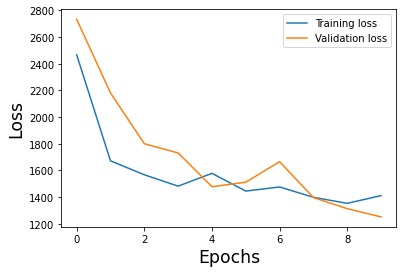

In [10]:
# Train VAE
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

In [11]:
# Check reproducibility of VAE training
template_path = "data/test_vae_log.tsv"
output_path = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(np.isclose(
    pd.read_csv(output_path, sep="\t").values,
    pd.read_csv(template_path, sep="\t").values
))

AssertionError: 

## Simulate data by random sampling

In [ ]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_random_sampling(
    normalized_data_file,
    train_architecture,
    dataset_name,
    analysis_name,
    num_simulated_samples,
    local_dir,
    base_dir,
)

In [ ]:
simulated_data.head()

## Visualize random sampled compendium

In [ ]:
# Read data
normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

In [ ]:
normalized_data.head()

In [ ]:
model = umap.UMAP(random_state=123).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [ ]:
# UMAP embedding of simulated data

simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

In [ ]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2'))
g_input_sim += geom_point(aes(color='dataset'),alpha=0.3)
g_input_sim += labs(x = "UMAP 1",
                    y = "UMAP 2", 
                    title = "Original and simulated data")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)

)

print(g_input_sim)